In [1]:
import pandas as pd
import torch
import time
import numpy as np
import warnings
from gensim.models.word2vec import Word2Vec
from model_siamese import BatchProgramCC
from torch.autograd import Variable
from sklearn.metrics import precision_recall_fscore_support
warnings.filterwarnings('ignore')
import sys
import argparse
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

/Users/konstantinos/Desktop/virtualenvs/astnn/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def get_batch(dataset, idx, bs):
    tmp = dataset.iloc[idx: idx+bs]
    x1, x2, labels = [], [], []
    for _, item in tmp.iterrows():
        x1.append(item['code_x'])
        x2.append(item['code_y'])
        labels.append([item['label']])
    return x1, x2, torch.FloatTensor(labels)

In [3]:
# Contrastive loss function
def contrastive_loss(embedding1, embedding2, label, margin=1.0):
    distance = torch.nn.functional.pairwise_distance(embedding1, embedding2)

    loss = torch.mean((1 - label) * 0.5 * torch.pow(distance, 2) +
                      label * 0.5 * torch.pow(torch.clamp(margin - distance, min=0.0), 2))
    #print(distance) # Should not vanish to zero
    return loss

In [4]:
root = 'data/'
lang = 'java'

In [5]:
all_data = pd.read_pickle(root+lang+'/all/blocks.pickle').sample(frac=1)
all_data['label'] = 1 - all_data['label']

In [6]:
word2vec = Word2Vec.load(root+lang+"/all/embedding/node_w2v_128").wv
MAX_TOKENS = word2vec.vectors.shape[0]
EMBEDDING_DIM = word2vec.vectors.shape[1]
embeddings = np.zeros((MAX_TOKENS + 1, EMBEDDING_DIM), dtype="float32")
embeddings[:word2vec.vectors.shape[0]] = word2vec.vectors

In [7]:
HIDDEN_DIM = 100
ENCODE_DIM = 128
LABELS = 1
EPOCHS = 5
BATCH_SIZE = 32
USE_GPU = torch.cuda.is_available()

all_functionalities = all_data['functionality_id'].unique()
all_functionalities.sort()

In [8]:
ii = 2

In [23]:
# Initialize model
model = BatchProgramCC(EMBEDDING_DIM,HIDDEN_DIM,MAX_TOKENS+1,ENCODE_DIM,LABELS,BATCH_SIZE,
                            USE_GPU, embeddings)
if USE_GPU:
    model.cuda()

parameters = model.parameters()
#optimizer = torch.optim.Adamax(parameters, lr=0.0001)
optimizer = torch.optim.Adam(parameters, lr=1e-3)


In [24]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [25]:
model

BatchProgramCC(
  (encoder): BatchTreeEncoder(
    (embedding): Embedding(2957, 128)
    (W_c): Linear(in_features=128, out_features=128, bias=True)
  )
  (bigru): GRU(128, 100, batch_first=True, bidirectional=True)
  (hidden2label): Linear(in_features=200, out_features=1, bias=True)
  (batch_norm): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [26]:
train_data_t = all_data[all_data['functionality_id'] != ii]
test_data_t = all_data[all_data['functionality_id'] == ii]

In [27]:
margin=50

In [28]:
prev_epoch_f1 = 0

In [29]:
def eval_model(model, test_data_t):
    model.eval()
    similarity_scores = []
    trues = []
    iTest = 0
    
    while iTest < len(test_data_t):
        batch = get_batch(test_data_t, iTest, BATCH_SIZE)
        iTest += BATCH_SIZE
        test1_inputs, test2_inputs, test_labels = batch
        if USE_GPU:
            test_labels = test_labels.cuda()
    
        model.batch_size = len(test_labels)
        model.hidden = model.init_hidden()
        with torch.no_grad():
            embeddings1 = model(test1_inputs)
            embeddings2 = model(test2_inputs)
        similarity_score = torch.nn.functional.cosine_similarity(embeddings1, embeddings2)
    
        loss = contrastive_loss(embeddings1, embeddings2, Variable(test_labels), margin=margin)
    
        # calc testing acc
        similarity_scores.extend(similarity_score.cpu())
        trues.extend(1 - test_labels.cpu().numpy())
    
    
    trues = np.array(trues)
    


    max_Acc = -np.inf
    for similarity_threshold_int in range(-5, 10):
        similarity_threshold = similarity_threshold_int/10
        # Classify code pairs based on the similarity score and threshold
        predicted_labels = (np.array(similarity_scores) > similarity_threshold)
        acc = 1-np.sum(np.abs(predicted_labels-np.transpose(trues)))/trues.shape[0]
        P, R, F1, _ = precision_recall_fscore_support(predicted_labels, trues, average='binary', pos_label=1)
    
    
        if acc > max_Acc:
            max_Acc = acc
            best_similarity_threshold = similarity_threshold

    predicted_labels = np.array(similarity_scores) > best_similarity_threshold
    p, r, f, _ = precision_recall_fscore_support(trues, predicted_labels, average='binary')
    acc = 1-np.sum(np.abs(predicted_labels-np.transpose(trues)))/trues.shape[0]
    print("F1=%.3f, P=%.3f, R=%.3f, A=%.3f for similarity threshold %0.2f" % (f, p, r, acc, best_similarity_threshold))


    max_F1 = -np.inf
    for similarity_threshold_int in range(-5, 10):
        similarity_threshold = similarity_threshold_int/10
        # Classify code pairs based on the similarity score and threshold
        predicted_labels = (np.array(similarity_scores) > similarity_threshold)
        acc = 1-np.sum(np.abs(predicted_labels-np.transpose(trues)))/trues.shape[0]
        P, R, F1, _ = precision_recall_fscore_support(predicted_labels, trues, average='binary', pos_label=1)
    
    
        if F1 > max_F1:
            max_F1 = F1
            best_similarity_threshold = similarity_threshold
            
    predicted_labels = np.array(similarity_scores) > best_similarity_threshold
    p, r, f, _ = precision_recall_fscore_support(trues, predicted_labels, average='binary')
    acc = 1-np.sum(np.abs(predicted_labels-np.transpose(trues)))/trues.shape[0]
    print("F1=%.3f, P=%.3f, R=%.3f, A=%.3f for similarity threshold %0.2f" % (f, p, r, acc, best_similarity_threshold))


    sys.stdout.flush()
    model.train()
    return f, similarity_scores

In [ ]:
for epoch in range(5):
    loss_arr_train = []
    i = 0
    while i < len(train_data_t):
        model.train()
        batch = get_batch(train_data_t, i, BATCH_SIZE)
        train1_inputs, train2_inputs, train_labels = batch
        if USE_GPU:
            train1_inputs, train2_inputs, train_labels = train1_inputs, train2_inputs, train_labels.cuda()
    
        model.zero_grad()
        model.batch_size = len(train_labels)
        model.hidden = model.init_hidden()
    
        embeddings1 = model(train1_inputs)
        embeddings2 = model(train2_inputs)
    
        loss = contrastive_loss(embeddings1, embeddings2, Variable(train_labels), margin=margin)
        loss.backward()
        optimizer.step()
    
        loss_arr_train.append(loss.detach().numpy())
        if (i/BATCH_SIZE) % 50 == 0:
            print(i/BATCH_SIZE)
            print(loss.detach().numpy())
            t1 = torch.nn.functional.pairwise_distance(embeddings1, embeddings2).detach().numpy()
            t2 = train_labels.cpu()

            idx_clones = (t2 == 0).squeeze()
            idx_non_clones = (t2 == 1).squeeze()
            print("Clones:")
            print(t1[idx_clones])
            print(t1[idx_clones].mean())
            print("Non clones:")
            print(t1[idx_non_clones])
            print(t1[idx_non_clones].mean())

            f, similarity_scores = eval_model(model, test_data_t)
            print()
        i += BATCH_SIZE

    
    f, similarity_scores = eval_model(model, test_data_t)

    if f<prev_epoch_f1:
        print("Lower F1 than previous epoch. Early stopping...")
        sys.stdout.flush()
        break
    else:
        prev_epoch_f1 = f

0.0
612.69867
Clones:
[1.4184115 2.0536978 1.2614927 1.380338  1.9560542 2.4514437 2.4777265
 1.3758324 1.7622333 2.0515735 3.7107935 1.3163167 1.5071658 2.45116
 2.4904187]
1.977644
Non clones:
[2.301823  1.0426943 2.9957225 2.120489  1.8279257 2.8327055 1.9550906
 2.9630136 1.4189116 2.4261918 1.2980686 2.5518832 2.4422278 1.3238126
 1.9770812 1.299955  2.1208324]
2.0528488
F1=0.664, P=0.509, R=0.956, A=0.518 for similarity threshold 0.90
F1=0.666, P=0.499, R=1.000, A=0.500 for similarity threshold 0.80

50.0
471.52356
Clones:
[6.5805573 9.068992  5.33086   5.983592  9.181604  6.856487  7.4570513
 5.679143  3.5738306 6.7663627 7.1993346 9.445034  7.7358108 3.6828368
 2.020886  3.3397684]
6.2438846
Non clones:
[ 6.1107116  4.2813773 12.069883   7.9062696  6.7129173 10.603179
  9.288277   9.8182745 10.172913   6.316908  11.874301   7.994757
 10.581822   6.668164   6.334236   8.022442 ]
8.422277
F1=0.598, P=0.621, R=0.577, A=0.613 for similarity threshold 0.80
F1=0.666, P=0.499, R=1.000

In [21]:
_, similarity_scores = eval_model(model, test_data_t)

F1=0.625, P=0.646, R=0.606, A=0.637 for similarity threshold 0.80
F1=0.666, P=0.499, R=1.000, A=0.499 for similarity threshold -0.50


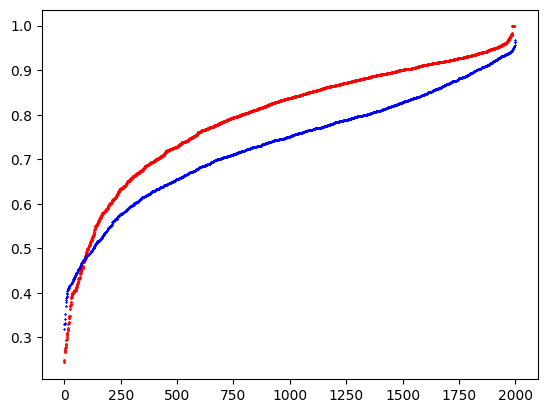

In [22]:
test_labels = np.array(test_data_t['label'])
similarity_scores = np.array(similarity_scores)
plt.plot(np.sort(similarity_scores[test_labels == 0]), 'ro', markersize=1)
plt.plot(np.sort(similarity_scores[test_labels == 1]), 'bx', markersize=1)

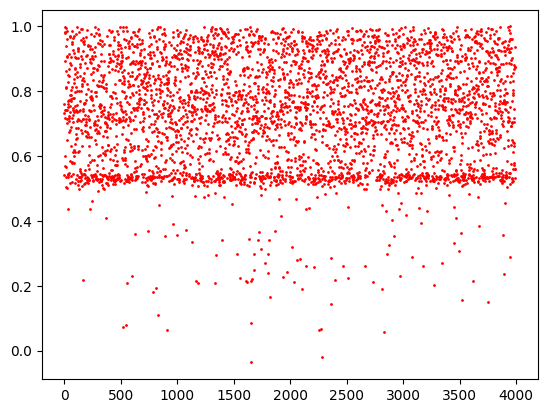

In [19]:
plt.plot(similarity_scores, 'ro', markersize=1)

In [41]:
predicted_labels = np.array(similarity_scores) > 0.9

trues = test_data_t['label']
p, r, f, _ = precision_recall_fscore_support(trues, predicted_labels, average='binary')
acc = 1-np.sum(np.abs(predicted_labels-np.transpose(trues)))/trues.shape[0]
print("(P,R,F1,A):%.3f, %.3f, %.3f, %.3f" % (p, r, f, acc))

(P,R,F1,A):0.500, 0.965, 0.659, 0.500
